# 머신러닝 모델 기반 다른 유저들의 승리 예측 분석

<목차>

1. 개요

2. EDA

3. Feature Engineering

4. 모델 개발

5. 모델 평가

---
---

## 개요

### 1. 목적
- 승리 예측 모델 개발 및 특성 중요도 분석
    - 승리에 주요하게 영향을 미치는 특성을 파악하기 위함

### 2. 데이터 설명
- FC온라인 API를 통해 수집한 다른 유저들의 경기 데이터
- 득점한 선수에 관련한 데이터는 분석에 활용하지 않고, 유저의 플레이 데이터만 활용한다.
- 매치ID 중복 데이터 존재 > 경기 기준이 아닌 골 기준으로 ROW가 집계됨(득점 좌표 데이터 활용하기 위함)
- API를 통해 호출한 데이터를 가공하여 다운 받은 CSV 파일을 호출한다.

### 3. 분석 환경 조성

#### ㄴ 라이브러리 호출

In [1]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import plotly.express as px
from sklearn.neighbors import NearestNeighbors


from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

#### ㄴ 데이터 호출

In [2]:
# 데이터 프레임 생성
match_df_1 = pd.read_csv('data/250324_recent_matches.csv', encoding='utf-8-sig')
match_df_2 = pd.read_csv('data/250325_recent_matches.csv', encoding='utf-8-sig')
match_df_3 = pd.read_csv('data/250326_recent_matches.csv', encoding='utf-8-sig')
match_df_4 = pd.read_csv('data/250327_recent_matches.csv', encoding='utf-8-sig')

In [3]:
# 각 데이터 프레임 크기 확인
print(match_df_1.shape) # 3/24기준 최근 100경기 데이터
print(match_df_2.shape) # 3/25기준 최근 100경기 데이터
print(match_df_3.shape) # 3/26기준 최근 100경기 데이터
print(match_df_4.shape) # 3/27기준 최근 100경기 데이터

(86, 43)
(738, 43)
(433, 43)
(489, 43)


In [4]:
# 데이터 프레임 확인
match_df_1.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


In [5]:
# 데이터 프레임 확인
match_df_2.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e1f18d273fbc4a46b37f9b,2025-03-24T23:59:37,50,55c2061645c1492e95e62eed782af8f8,나이기면축잘알,승,1,0,0,0,...,182,0.788435,0.329238,1,3,820239085,True,825231866,False,False
1,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,210,0.895556,0.502413,1,3,820020801,True,828231747,False,True
2,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,660,0.933971,0.530024,3,2,825165153,False,-1,False,True
3,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,831,0.881881,0.508044,1,3,810252371,True,828231747,False,True
4,67e1f1017f5021c485400a6f,2025-03-24T23:58:01,50,87646786082028345ae3ccb7d3f08f50,LaCintura,승,1,0,0,0,...,603,0.875750,0.598381,1,1,820020801,False,-1,False,True


In [6]:
# 데이터 프레임 확인
match_df_3.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e36cd96d41982876fb9103,2025-03-26T02:59:23,50,3b73131f3613116973763ec4d1bba7a8,남공익,패,2,0,0,0,...,308,0.890763,0.421532,3,2,283190460,False,-1,False,True
1,67e36cd96d41982876fb9103,2025-03-26T02:59:23,50,3b73131f3613116973763ec4d1bba7a8,남공익,패,2,0,0,0,...,1076,0.959023,0.647952,2,2,804259399,True,827226764,False,True
2,67e36cd96d41982876fb9103,2025-03-26T02:59:23,50,edbbb913e21fdd3e144f1780fda0a134,뚝배기뚝딱얌미,승,1,1,0,0,...,145,0.850520,0.362283,1,2,290200104,True,807202126,False,True
3,67e36cd96d41982876fb9103,2025-03-26T02:59:23,50,edbbb913e21fdd3e144f1780fda0a134,뚝배기뚝딱얌미,승,1,1,0,0,...,1252,0.785862,0.399597,4,3,807202126,True,290200104,False,False
4,67e36cd5b2f0dc890f864272,2025-03-26T02:59:44,50,d89e301bb198cb217466417e985479e9,레알레전드1,승,1,1,0,0,...,956,0.891288,0.560871,2,3,827005419,True,825005673,False,True


In [7]:
# 데이터 프레임 확인
match_df_4.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e4780d5f4013349c5c4ce3,2025-03-26T21:59:40,50,f3cbfbf19ad98f9a4c825292769b0134,SP0T1FY,패,2,0,0,0,...,901,0.971764,0.549338,2,3,827028130,True,802190043,False,True
1,67e4780d5f4013349c5c4ce3,2025-03-26T21:59:40,50,f3cbfbf19ad98f9a4c825292769b0134,SP0T1FY,패,2,0,0,0,...,1027,0.912358,0.390454,1,1,827028130,True,802190043,False,True
2,67e4780d5f4013349c5c4ce3,2025-03-26T21:59:40,50,ae8290ad04b5c668ef77656787e763d7,드롭더비치,승,1,0,0,0,...,1285,0.924991,0.448924,1,3,274254642,True,814222000,False,True
3,67e4780d5f4013349c5c4ce3,2025-03-26T21:59:40,50,ae8290ad04b5c668ef77656787e763d7,드롭더비치,승,1,0,0,0,...,102,0.932262,0.535398,3,3,827005661,True,829238794,False,True
4,67e4779df74d815b672e4576,2025-03-26T21:58:04,50,9e70559a2eec8ac2adb479c61e231280,오리너구리FC,승,1,0,0,0,...,156,0.837167,0.453312,6,1,827005419,False,-1,False,False


- 데이터 프레임 병합
    - 각 날짜에 최근 100경기를 API로 호출했으나 몇 경기에서 error 코드가 발생해 집계가 되지 않는 문제 발생
    - 최대한 많은 모수 확보를 위해 해당 데이터 제외하고 나머지 데이터들 호출

In [8]:
# 데이터 병합
match_df = pd.concat([match_df_1,match_df_2,match_df_3,match_df_4], axis=0, ignore_index=True)
match_df.head()

,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,goalTime,x,y,type,result,spId,assist,assistSpId,hitPost,inPenalty
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,127,0.950309,0.483909,6,1,291206594,False,-1,False,True
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,425,0.880318,0.622680,2,2,265216409,False,-1,False,True
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,490,0.827593,0.522800,2,3,289049072,True,814166149,False,False
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,575,0.941004,0.672179,1,3,829231447,True,252214100,False,True
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,154,0.890730,0.583691,2,3,268192181,True,252214100,False,True


---

## EDA

### 1. 데이터 확인

In [9]:
# 데이터 크기 확인
match_df.shape

(1746, 43)

In [10]:
# 기술 통계 분석
match_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
matchId,1746,178,67e36cc6ac5987898d5d6ba3,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchDate,1746,161,2025-03-24T23:59:57,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchType,1746.0,NaN,NaN,NaN,50.0,0.0,50.0,50.0,50.0,50.0,50.0
ouid,1746,285,13441f01cb6ba2fa125b7192c229c9e9,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nickname,1746,285,문쭈쫀합,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchResult,1746,3,승,1093,NaN,NaN,NaN,NaN,NaN,NaN,NaN
matchEndType,1746.0,NaN,NaN,NaN,0.52291,0.630452,0.0,0.0,0.0,1.0,2.0
foul,1746.0,NaN,NaN,NaN,0.468499,0.695778,0.0,0.0,0.0,1.0,3.0
injury,1746.0,NaN,NaN,NaN,0.111111,0.31436,0.0,0.0,0.0,0.0,1.0
redCards,1746.0,NaN,NaN,NaN,0.006873,0.082641,0.0,0.0,0.0,0.0,1.0


In [11]:
# 데이터 정보 확인
match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746 entries, 0 to 1745
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matchId              1746 non-null   object 
 1   matchDate            1746 non-null   object 
 2   matchType            1746 non-null   int64  
 3   ouid                 1746 non-null   object 
 4   nickname             1746 non-null   object 
 5   matchResult          1746 non-null   object 
 6   matchEndType         1746 non-null   int64  
 7   foul                 1746 non-null   int64  
 8   injury               1746 non-null   int64  
 9   redCards             1746 non-null   int64  
 10  yellowCards          1746 non-null   int64  
 11  possession           1746 non-null   int64  
 12  averageRating        1746 non-null   float64
 13  dribble              1746 non-null   int64  
 14  cornerKick           1746 non-null   int64  
 15  offsideCount         1746 non-null   i

#### ㄴ 데이터 분포 시각화

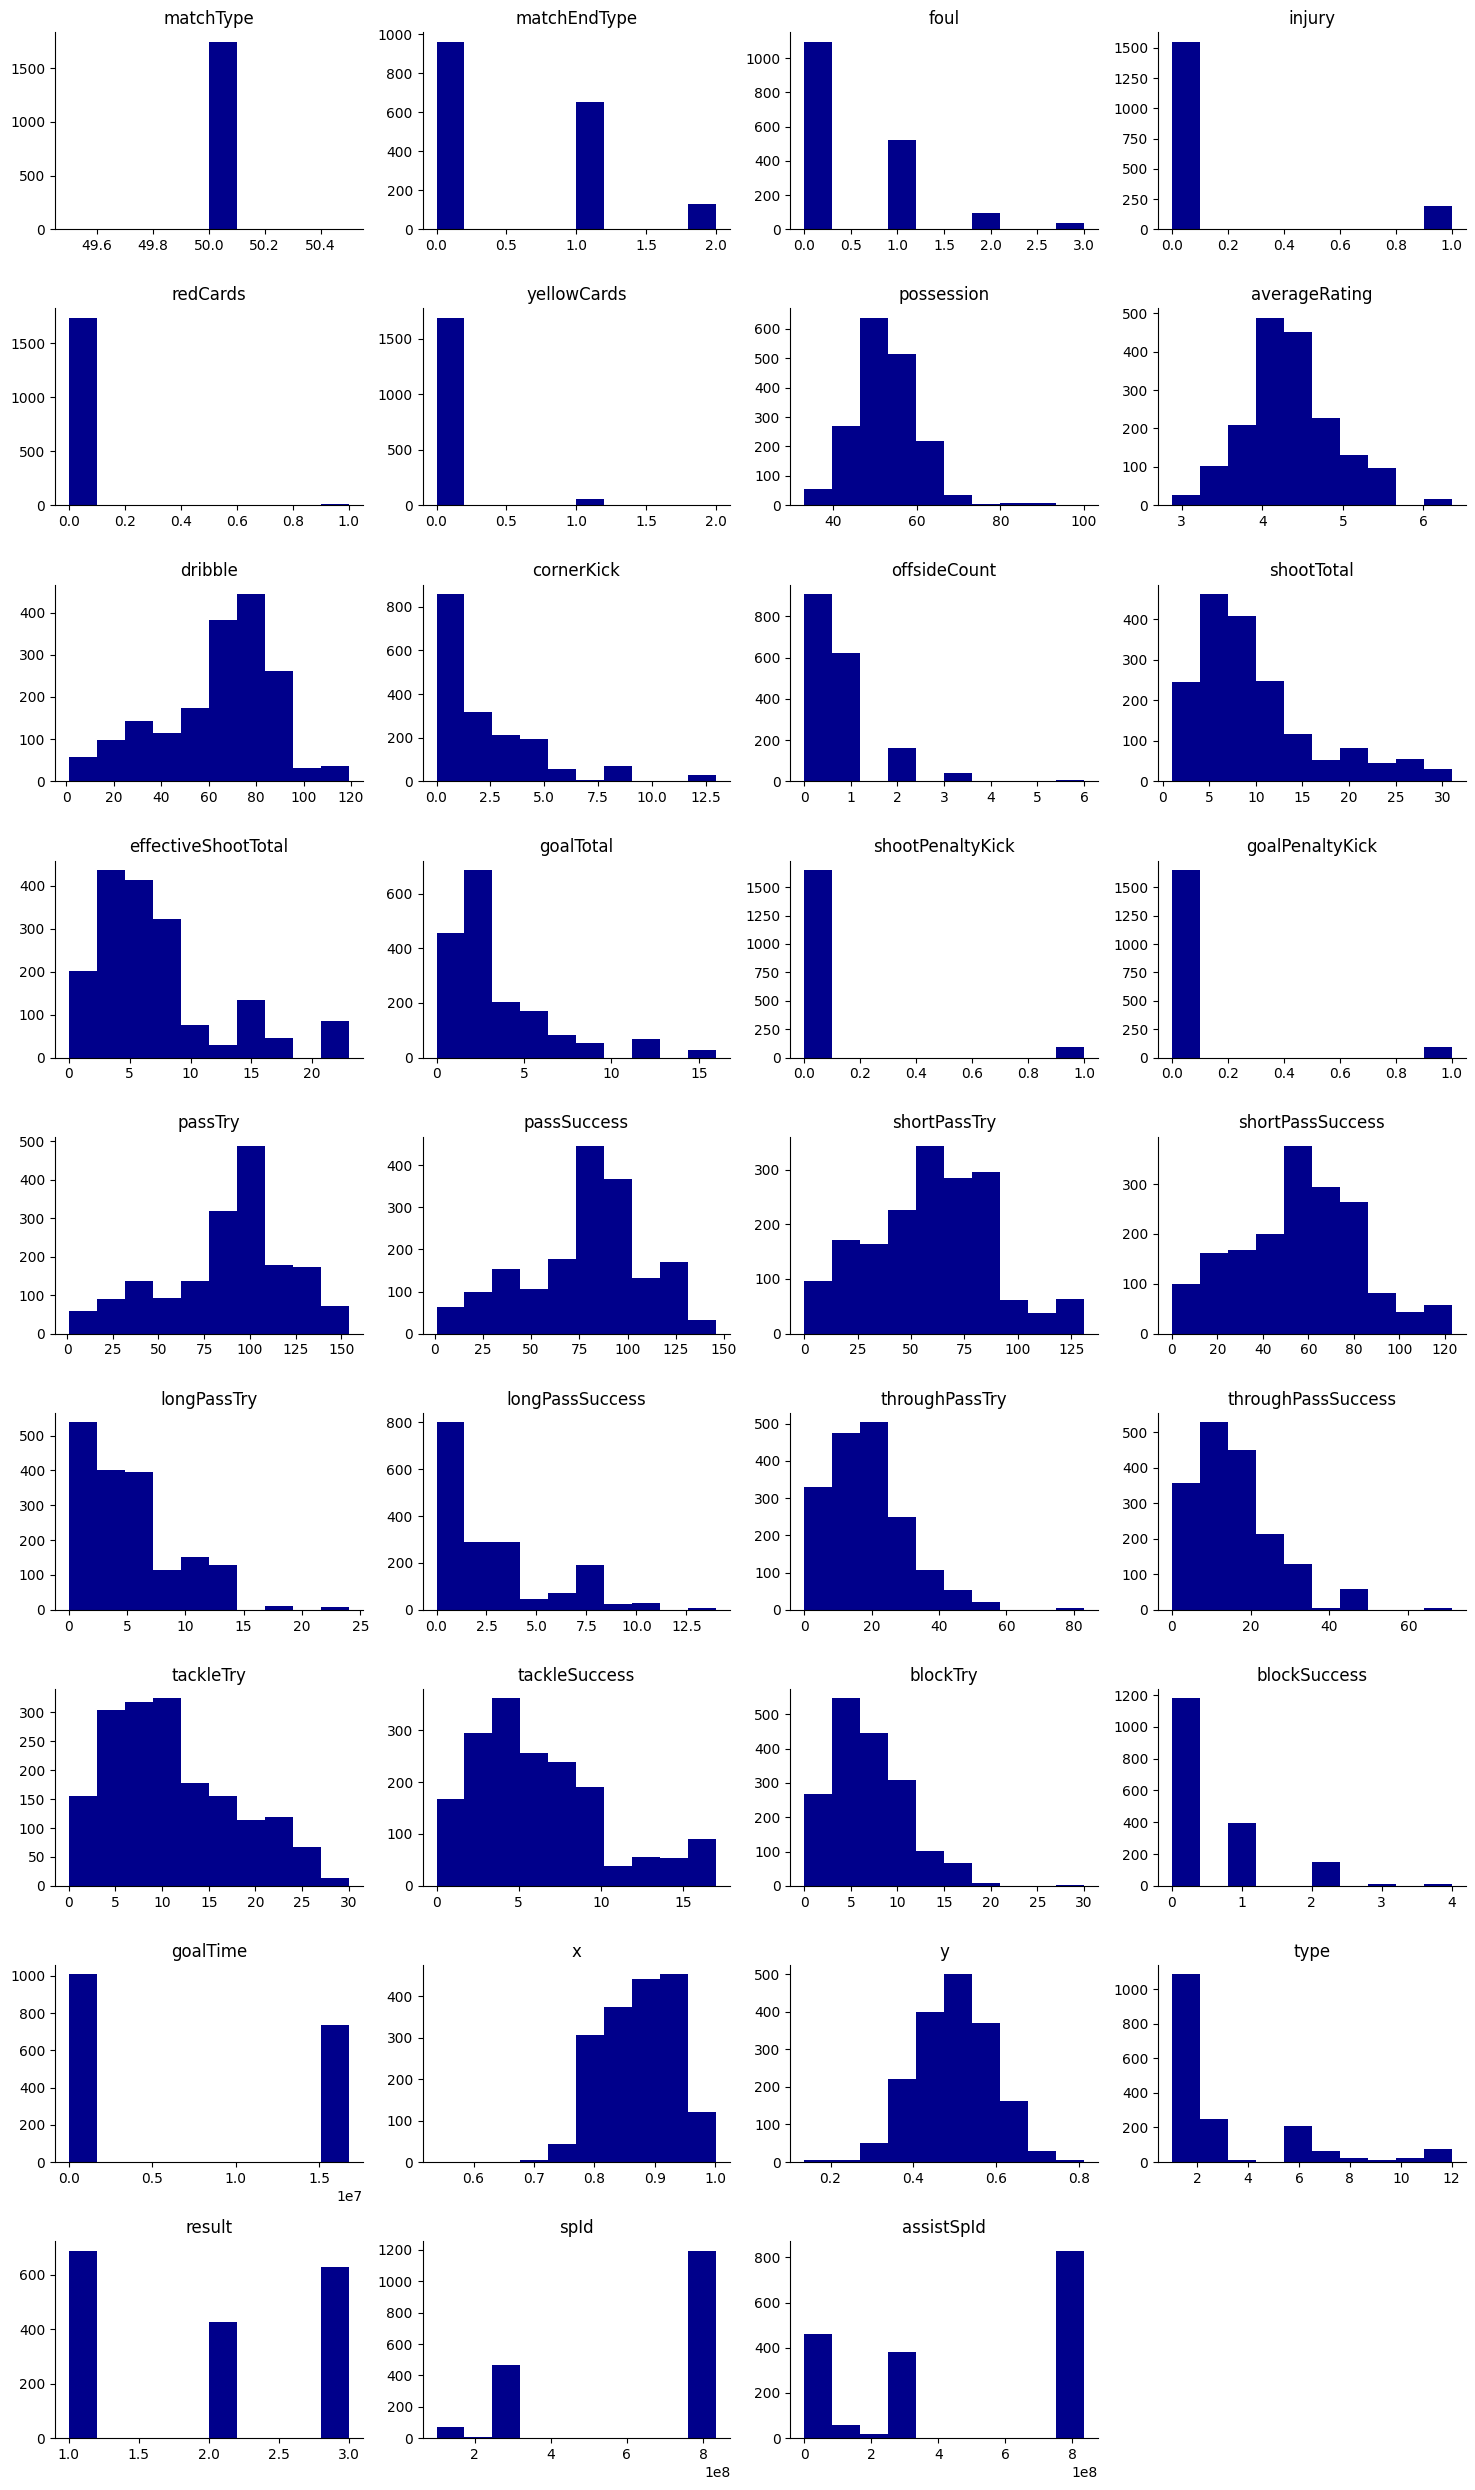

In [12]:
# 데이터 분포 시각화
# 변수 선별
numeric_df = match_df.select_dtypes(include=['number'])
cols = numeric_df.columns

# 서브플롯 생성
fig, axes = plt.subplots(9, 4, figsize=(15, 25))
axes = axes.flatten()

# 각 컬럼에 대해 히스토그램 그리기
for i, column in enumerate(cols):
    axes[i].hist(numeric_df[column].dropna(), color='darkblue', alpha=1)
    axes[i].set_title(column)
    axes[i].grid(axis='x', linestyle=':', color='darkgrey')
    axes[i].grid(axis='x')
    axes[i].spines[['top','right']].set_visible(False)

# 빈 서브플롯 숨기기
for j in range(len(cols), len(axes)):
    axes[j].axis("off")

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

> 결론
- spId, assistSpId는 선수 고유 ID
- goalTime의 max값이 3분위수와 차이가 많이 난다.
- 연속형 변수 중, goalTime을 제외하고는 특별한 이상치가 기술 통계량에서는 확인되지 않는다.
- matchResult는 승리 여부로, 범주형 변수이자 머신러닝 모델의 종속변수가 된다.(이진수가 아닌 '승','패'로 object 타입으로 저장되어 있다.)
- Try와 Success 데이터를 통해 성공확률을 도출할 수 있다.(ex. 패스, 숏패스, 롱패스, 스루패스, 태클 등)

### 2. 데이터 전처리

#### ㄴ 결측값 처리

In [13]:
# 결측값 확인
match_df.isna().sum()

matchId                0
matchDate              0
matchType              0
ouid                   0
nickname               0
matchResult            0
matchEndType           0
foul                   0
injury                 0
redCards               0
yellowCards            0
possession             0
averageRating          0
dribble                0
cornerKick             0
offsideCount           0
shootTotal             0
effectiveShootTotal    0
goalTotal              0
shootPenaltyKick       0
goalPenaltyKick        0
passTry                0
passSuccess            0
shortPassTry           0
shortPassSuccess       0
longPassTry            0
longPassSuccess        0
throughPassTry         0
throughPassSuccess     0
tackleTry              0
tackleSuccess          0
blockTry               0
blockSuccess           0
goalTime               0
x                      0
y                      0
type                   0
result                 0
spId                   0
assist                 0


#### ㄴ 중복값 처리

- 데이터는 골 기준으로 ROW가 생성되고 있다.
- 한 경기에 여러 골이 발생하므로 matchId는 중복값 발생
- 따라서 식별자로 사용할 수 없으므로 모든 행에 대해서 중복값이 있는지 체크한다.

In [61]:
# 중복값 확인
match_df.duplicated().sum()

np.int64(0)

- 득점과 관련된 데이터(득점 슛 위치 좌표, 슛 유형, 득점 시간, 득점 선수, 어시스트 선수)는 모델 생성에 활용하지 않고, 따로 세부 분석을 통해 인사이트를 도출하기로 한다.
    - ROW를 경기 단위로 생성하기 위함

In [71]:
# 데이터 누수 방지를 위해 데이터 프레임 복제
preprocessed_df = match_df.copy()

# 득점과 관련된 변수 및 'ouid' 삭제
preprocessed_df = preprocessed_df.drop(columns=['goalTime', 'x', 'y', 'type','result', 'spId', 'assist', 'assistSpId', 'hitPost', 'inPenalty'])

In [72]:
# 변수 삭제 확인
preprocessed_df.columns

Index(['matchId', 'matchDate', 'matchType', 'ouid', 'nickname', 'matchResult',
       'matchEndType', 'foul', 'injury', 'redCards', 'yellowCards',
       'possession', 'averageRating', 'dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry',
       'blockSuccess'],
      dtype='object')

In [73]:
# 데이터 확인
print(preprocessed_df.shape)
preprocessed_df.head()

(1746, 33)


,matchId,matchDate,matchType,ouid,nickname,matchResult,matchEndType,foul,injury,redCards,...,shortPassTry,shortPassSuccess,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess
0,67e13ae44065376a668ffd79,2025-03-24T10:59:34,50,c69d1fc3d30168bae289e407f866e913,DRX엄지렐라,패,2,0,0,0,...,0,0,0,0,1,1,1,1,0,0
1,67e13aa29ed34d74ce8f1afa,2025-03-24T10:59:57,50,a4c86fd92dbadafe4acef48dc03579ea,소각영도점,패,2,0,0,0,...,7,7,2,0,3,3,1,1,1,0
2,67e13a8aa1826dbfeede1857,2025-03-24T10:58:33,50,c1985d83d9eaf2451042c6d93e566b14,너없이는못살아,승,1,0,0,0,...,3,3,0,0,0,0,1,0,1,0
3,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,11,10,0,0,3,3,3,1,0,0
4,67e13a8823330c0f0c5e71d4,2025-03-24T10:59:15,50,74b31668c844b9094f81f679028f42f7,냠냐치치,승,1,0,0,0,...,11,10,0,0,3,3,3,1,0,0


#### (*)새로운 데이터 테이블 생성 - ouid로 그룹핑
- 유저별로 매치 디테일 정보와 승, 패 여부가 집계되어야 모델을 개발할 수 있기 때문에 matchId, ouid기준으로 그룹핑 진행(matchId는 날짜와 경기결과 컬럼 merge할때만 활용)
- matchEndType값이 0인 데이터만 남기기(매치 정상종료 데이터만 남기기)
- 'matchId', 'nickname','matchType' 삭제 : 분석에 미활용
- ouid당 하나의 값을 가지는 데이터들 : 'matchDate', 'matchResult'
- 나머지 컬럼은 평균으로 집계해야 하나의 유저가 해당 경기에서 기록한 데이터가 된다.(현재는 골단위로 ROW가 집계되어 있어 골 관련 컬럼을 제외하고 동일한 경기 데이터가 중복 집계되어 있음)

In [74]:
# 몰수승, 몰수패는 정상적으로 종료되지 않은 매치이므로 제외한다.('matchEndType' == 0인 경우가 정상)
print(preprocessed_df['matchEndType'].unique())
preprocessed_df['matchEndType'].value_counts()

[2 1 0]


matchEndType
0    962
1    655
2    129
Name: count, dtype: int64

In [75]:
# 정상종료 매치만 남기기
preprocessed_df = preprocessed_df[preprocessed_df['matchEndType'] == 0]

In [76]:
# 합계로 산출해야하는 변수들
match_group_mean_df = preprocessed_df.groupby(['matchId','ouid'])[[
        'foul', 'injury', 'redCards', 'yellowCards','dribble', 'cornerKick', 'offsideCount',
       'shootTotal', 'effectiveShootTotal', 'goalTotal', 'shootPenaltyKick',
       'goalPenaltyKick', 'passTry', 'passSuccess', 'shortPassTry',
       'shortPassSuccess', 'longPassTry', 'longPassSuccess', 'throughPassTry',
       'throughPassSuccess', 'tackleTry', 'tackleSuccess', 'blockTry', 'blockSuccess','possession', 'averageRating']].mean()
match_group_mean_df = match_group_mean_df.reset_index()

print(match_group_mean_df.shape)
match_group_mean_df.head()

(135, 28)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,longPassTry,longPassSuccess,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating
0,67e1ef5251948855f7992228,90750aca50294b5410f5a2d58e833c4f,0.0,0.0,0.0,0.0,95.0,1.0,0.0,8.0,...,6.0,6.0,34.0,32.0,14.0,10.0,6.0,1.0,52.0,4.07778
1,67e1ef5251948855f7992228,c006f3ce90a6a5b06ae6abd559beb277,0.0,1.0,0.0,0.0,69.0,2.0,0.0,6.0,...,3.0,1.0,25.0,23.0,23.0,13.0,14.0,1.0,48.0,4.21111
2,67e1ef54c9355af27ece6b91,23a04668f085056edd6a65f301252097,1.0,0.0,0.0,0.0,65.0,0.0,0.0,9.0,...,4.0,2.0,14.0,9.0,13.0,11.0,14.0,1.0,51.0,4.60556
3,67e1ef54c9355af27ece6b91,f1f45857e2f2e50a98a063f0818ea914,0.0,0.0,0.0,0.0,69.0,4.0,1.0,9.0,...,7.0,2.0,14.0,14.0,10.0,4.0,8.0,0.0,49.0,3.72222
4,67e1ef55c20294fff2bceef0,21d17218c3edd165e1ecef267db448a2,2.0,0.0,0.0,1.0,83.0,0.0,1.0,3.0,...,5.0,4.0,9.0,6.0,15.0,7.0,5.0,2.0,54.0,4.09444


In [78]:
# matchDate와 matchResult 결과 컬럼
date_result_tmp_df = preprocessed_df.drop_duplicates(subset=['matchId','ouid'],keep='last')
date_result_tmp_df = date_result_tmp_df[['matchId','ouid', 'matchDate','matchResult']]
date_result_tmp_df

,matchId,ouid,matchDate,matchResult
297,67e1efa4ffc153fd6da558c2,a22088598a63b2149d6b51b797e79824,2025-03-24T23:59:48,패
302,67e1efa4ffc153fd6da558c2,4442747c1870088307c71bb79e7fa27e,2025-03-24T23:59:48,승
309,67e1efa18d2e905486bb5b18,8a91a5be8fe6c62be629501ae8f67a57,2025-03-24T23:59:52,무
323,67e1efa18d2e905486bb5b18,819c21bcaf015547b6126b8fb80a2887,2025-03-24T23:59:52,무
352,67e1ef922c87eabd1bc08a3e,b58663af9e55ca45d20e0be659b5fa34,2025-03-24T23:59:57,무
...,...,...,...,...
1702,67e47584212dcbccb45c1386,f09c00a266c1cd57df2230a631ff63fb,2025-03-26T21:55:18,무
1706,67e47584212dcbccb45c1386,978208b307adc3d9716c6cc3684cbf9c,2025-03-26T21:55:18,무
1729,67e47578152a1b628e75ee46,eabcf61dbf9a46d52791742e68b418d7,2025-03-26T21:56:59,승
1732,67e47572bba0c5561ae9e48f,a35df4bca27d34ab4d2d0e624c6a0e9c,2025-03-26T21:55:38,패


- matchDate, matchResult 병합

In [ ]:
# 최종 데이터 생성
match_merge_df = pd.merge(match_group_mean_df, date_result_tmp_df, how='inner', on=['matchId','ouid'])
print(match_merge_df.shape)
match_merge_df.head()

(135, 30)


,matchId,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,67e1ef5251948855f7992228,90750aca50294b5410f5a2d58e833c4f,0.0,0.0,0.0,0.0,95.0,1.0,0.0,8.0,...,34.0,32.0,14.0,10.0,6.0,1.0,52.0,4.07778,2025-03-24T23:59:20,무
1,67e1ef5251948855f7992228,c006f3ce90a6a5b06ae6abd559beb277,0.0,1.0,0.0,0.0,69.0,2.0,0.0,6.0,...,25.0,23.0,23.0,13.0,14.0,1.0,48.0,4.21111,2025-03-24T23:59:20,무
2,67e1ef54c9355af27ece6b91,23a04668f085056edd6a65f301252097,1.0,0.0,0.0,0.0,65.0,0.0,0.0,9.0,...,14.0,9.0,13.0,11.0,14.0,1.0,51.0,4.60556,2025-03-24T23:59:02,승
3,67e1ef54c9355af27ece6b91,f1f45857e2f2e50a98a063f0818ea914,0.0,0.0,0.0,0.0,69.0,4.0,1.0,9.0,...,14.0,14.0,10.0,4.0,8.0,0.0,49.0,3.72222,2025-03-24T23:59:02,패
4,67e1ef55c20294fff2bceef0,21d17218c3edd165e1ecef267db448a2,2.0,0.0,0.0,1.0,83.0,0.0,1.0,3.0,...,9.0,6.0,15.0,7.0,5.0,2.0,54.0,4.09444,2025-03-24T23:58:51,무


In [99]:
# matchId 삭제
match_merge_df = match_merge_df.drop(columns=['matchId'])
match_merge_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult
0,90750aca50294b5410f5a2d58e833c4f,0.0,0.0,0.0,0.0,95.0,1.0,0.0,8.0,6.0,...,34.0,32.0,14.0,10.0,6.0,1.0,52.0,4.07778,2025-03-24T23:59:20,무
1,c006f3ce90a6a5b06ae6abd559beb277,0.0,1.0,0.0,0.0,69.0,2.0,0.0,6.0,5.0,...,25.0,23.0,23.0,13.0,14.0,1.0,48.0,4.21111,2025-03-24T23:59:20,무
2,23a04668f085056edd6a65f301252097,1.0,0.0,0.0,0.0,65.0,0.0,0.0,9.0,6.0,...,14.0,9.0,13.0,11.0,14.0,1.0,51.0,4.60556,2025-03-24T23:59:02,승
3,f1f45857e2f2e50a98a063f0818ea914,0.0,0.0,0.0,0.0,69.0,4.0,1.0,9.0,5.0,...,14.0,14.0,10.0,4.0,8.0,0.0,49.0,3.72222,2025-03-24T23:59:02,패
4,21d17218c3edd165e1ecef267db448a2,2.0,0.0,0.0,1.0,83.0,0.0,1.0,3.0,3.0,...,9.0,6.0,15.0,7.0,5.0,2.0,54.0,4.09444,2025-03-24T23:58:51,무


#### ㄴ 이상치 처리

In [100]:
# 숫자형 변수
numeric_cols = match_merge_df.select_dtypes('number').columns
numeric_cols

Index(['foul', 'injury', 'redCards', 'yellowCards', 'dribble', 'cornerKick',
       'offsideCount', 'shootTotal', 'effectiveShootTotal', 'goalTotal',
       'shootPenaltyKick', 'goalPenaltyKick', 'passTry', 'passSuccess',
       'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess',
       'throughPassTry', 'throughPassSuccess', 'tackleTry', 'tackleSuccess',
       'blockTry', 'blockSuccess', 'possession', 'averageRating'],
      dtype='object')

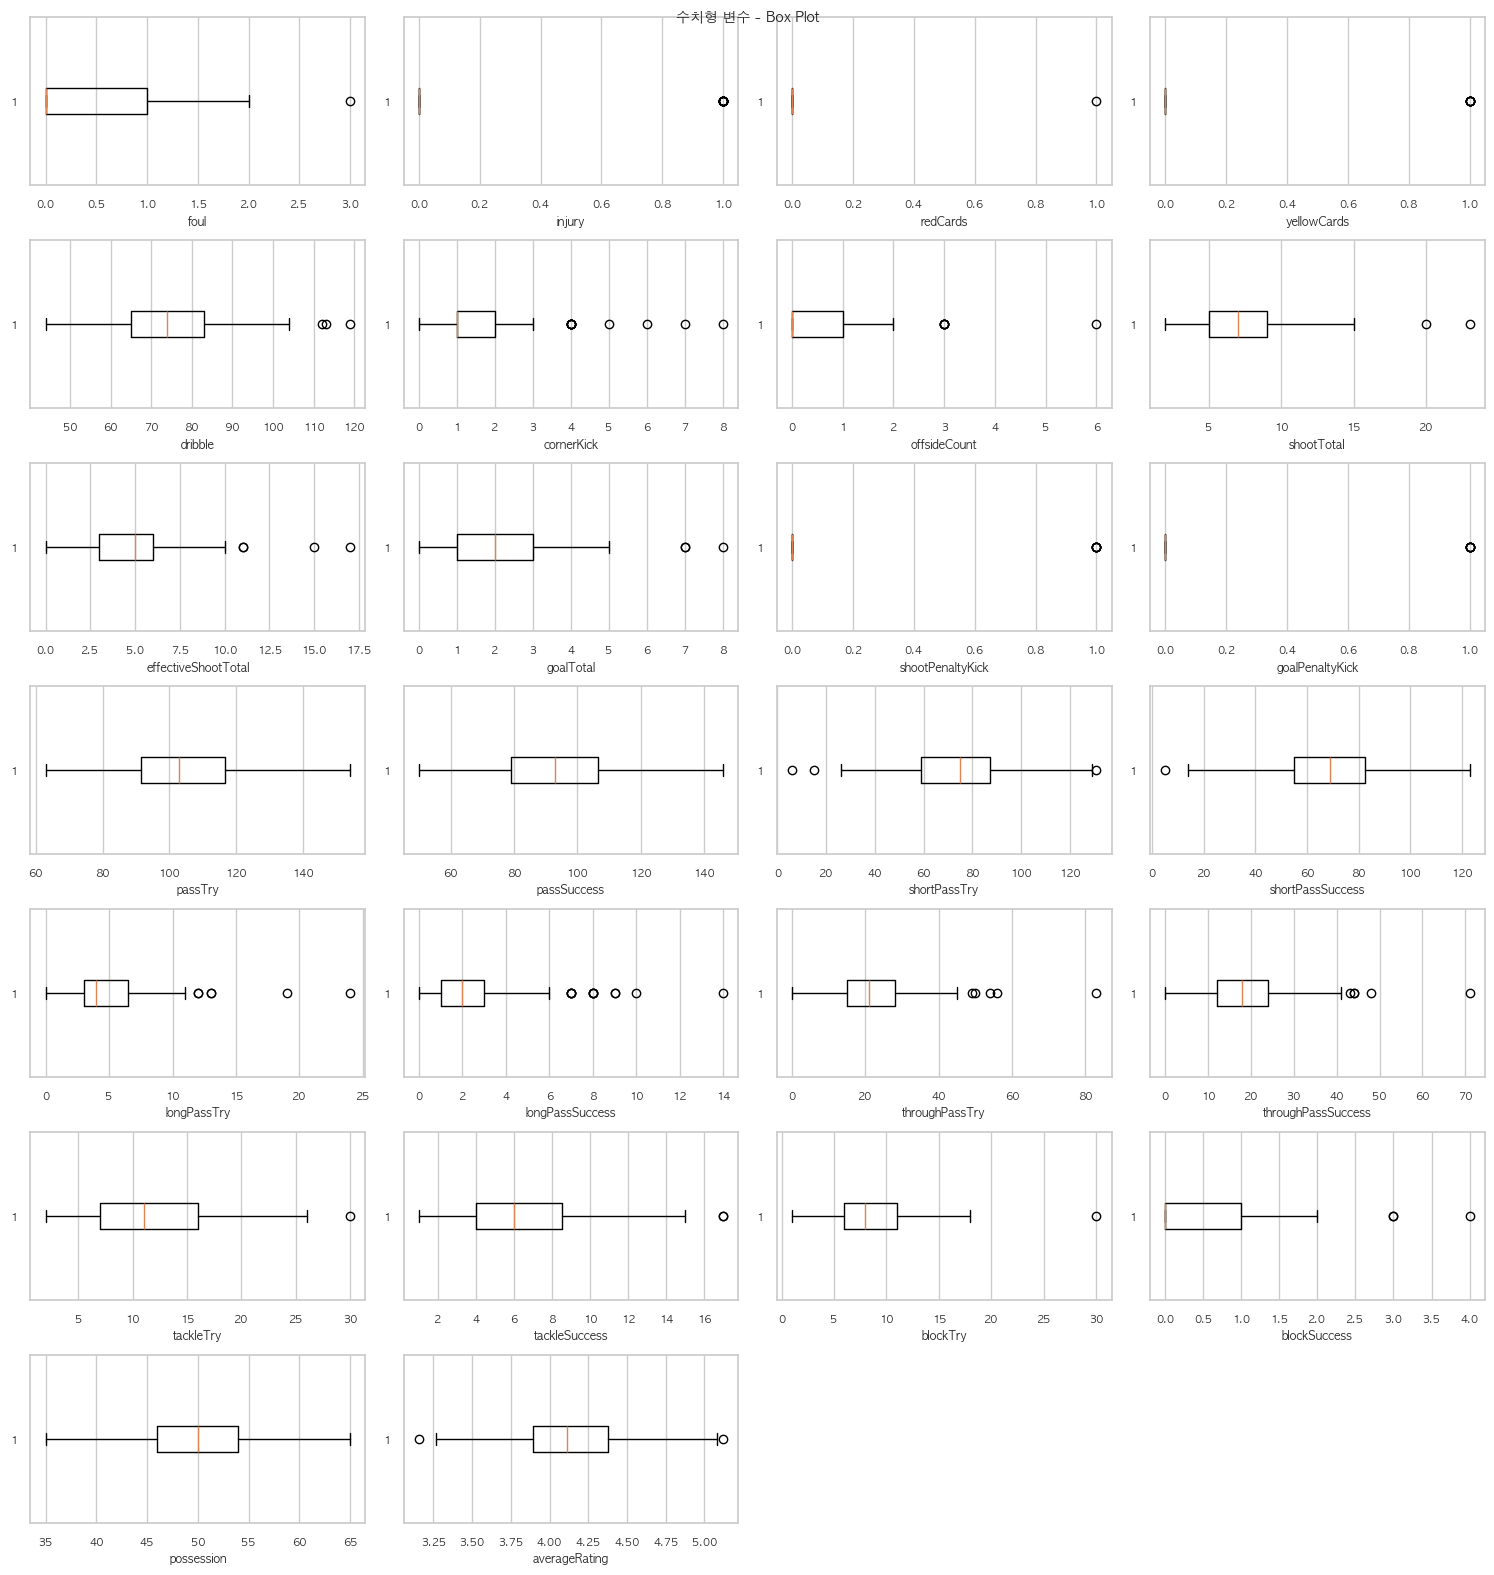

In [101]:
# 이상치 확인할 변수 선택
outlier_cols = numeric_cols

# 컬럼별 이상치 시각화
sns.set_theme(style='whitegrid',rc={'figure.figsize':(10,6)}, font_scale=0.7, font='AppleGothic')

fig, axes = plt.subplots(7,4,figsize=(15, 16))
axes = axes.flatten()

for i, col in enumerate(outlier_cols):
    axes[i].boxplot(match_merge_df[col],  vert=False)
    axes[i].set_xlabel(f'{col}')
    axes[i].set_xlabel(f'{col}')
    axes[i].grid(axis='y')

# 빈 서브플롯 숨기기
for j in range(len(outlier_cols), len(axes)):
    axes[j].axis("off")

fig.suptitle('수치형 변수 - Box Plot')

fig.tight_layout()
fig.show()

In [103]:
# 이상치 개수 확인
for col in outlier_cols:
  q1 = match_merge_df[col].quantile(0.25)
  q3 = match_merge_df[col].quantile(0.75)
  iqr = q3-q1
  outlier_count = len(match_merge_df[(match_merge_df[col] < (q1 - (1.5*iqr)))|(match_merge_df[col] > (q3 + (1.5*iqr)))])

  print(f"{col} - 이상치 개수: {outlier_count}", '/', f"비율: {round((outlier_count/len(match_merge_df))*100,2)}%")

foul - 이상치 개수: 1 / 비율: 0.74%
injury - 이상치 개수: 17 / 비율: 12.59%
redCards - 이상치 개수: 1 / 비율: 0.74%
yellowCards - 이상치 개수: 7 / 비율: 5.19%
dribble - 이상치 개수: 3 / 비율: 2.22%
cornerKick - 이상치 개수: 12 / 비율: 8.89%
offsideCount - 이상치 개수: 6 / 비율: 4.44%
shootTotal - 이상치 개수: 2 / 비율: 1.48%
effectiveShootTotal - 이상치 개수: 4 / 비율: 2.96%
goalTotal - 이상치 개수: 3 / 비율: 2.22%
shootPenaltyKick - 이상치 개수: 6 / 비율: 4.44%
goalPenaltyKick - 이상치 개수: 6 / 비율: 4.44%
passTry - 이상치 개수: 0 / 비율: 0.0%
passSuccess - 이상치 개수: 0 / 비율: 0.0%
shortPassTry - 이상치 개수: 3 / 비율: 2.22%
shortPassSuccess - 이상치 개수: 1 / 비율: 0.74%
longPassTry - 이상치 개수: 6 / 비율: 4.44%
longPassSuccess - 이상치 개수: 12 / 비율: 8.89%
throughPassTry - 이상치 개수: 5 / 비율: 3.7%
throughPassSuccess - 이상치 개수: 5 / 비율: 3.7%
tackleTry - 이상치 개수: 1 / 비율: 0.74%
tackleSuccess - 이상치 개수: 2 / 비율: 1.48%
blockTry - 이상치 개수: 1 / 비율: 0.74%
blockSuccess - 이상치 개수: 3 / 비율: 2.22%
possession - 이상치 개수: 0 / 비율: 0.0%
averageRating - 이상치 개수: 2 / 비율: 1.48%


> 결론

<특이사항>
- injury : 부상 수, 부상은 인게임에서 잘 발생하지 않아 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1과 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- foul : 파울 수, 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1, 2와 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- yellowCards, redCards : 대부분의 데이터가 0에 몰려 있어 사분위수로 이상치 탐지시 1과 같은 정상값도 이상치로 간주됨.(이상치 처리 X)
- goalTotal : 현실적으로 경기당 한 팀이 7~8개의 득점을 낼 수 있으므로(현실적인 수치이므로)
- averageRating : 경기 사후에 매겨지는 경기 평점이므로 경기 결과에 영향을 주지 않는다. 이상치 처리 필요성 X
- shootTotal : 총 슈팅 수가 1인 경기 또한 공격이 제대로 진행되지 않은 경기로써, 분석할 가치가 있으므로 이상치 처리 X
- shootPenaltyKick : 대부분의 경기에서 페널티킥이 발생하지 않으므로 1이 이상치로 관찰되는 것이며, 실질적인 이상치는 아니다.
- goalPenaltyKick : 위와 동일
- injury, cornerKick, longPassSuccess를 제외하고 모두 5%내외로 이상치 적게 발생

<처리 예정 사항>

- injury, cornerKick, longPassSuccess도 10%내외로 이상치가 많지 않고, 사분위수 이상치 탐지 범위 내에 들지 않은 데이터가 인사이트를 제공해줄 수 있다.
- 따라서 데이터를 살리면서 이상치 영향을 감소시키기 위해 `KNN알고리즘으로 이웃 평균치로 대치`
- 단, 위 <특이사항>에서 이상치로 처리하지 않는다고 기재한 변수는 제외하고 진행한다.(injury, foul, averageRating, shootTotal, shootPenaltyKick, goalPenaltyKick)

- KNN 활용 이상치 처리

In [110]:
try_success_cols = ['dribble', 'cornerKick','offsideCount','shootTotal','effectiveShootTotal','goalTotal', 'shortPassTry', 'shortPassSuccess', 'longPassTry', 'longPassSuccess' ,'throughPassTry','throughPassSuccess','tackleTry','tackleSuccess','blockTry','blockSuccess']

# 데이터 누수 방지를 위해 데이터프레임 복제
outlier_processed_df = match_merge_df.copy()

# KNN 모델을 사용하여 이웃 계산
knn = NearestNeighbors(n_neighbors=5)  # n_neighbors 값을 직접 설정

# 데이터로 학습
knn.fit(outlier_processed_df[try_success_cols])

# 각 샘플에 대해 가장 가까운 이웃까지의 거리 계산
distances, indices = knn.kneighbors(outlier_processed_df[try_success_cols])

# distance_threshold 값을 결정하는 방법 (상위 90% 거리값 기준)
distance_threshold = np.percentile(distances[:, -1], 90)

# 이상치 판별
outliers = distances[:, -1] > distance_threshold

# 이상치 대치 (예: 가까운 이웃의 평균값으로 대체)
for i in range(outlier_processed_df[try_success_cols].shape[0]):
    if outliers[i]:
        # 이상치인 경우, 해당 샘플의 이웃들의 평균값으로 대체
        outlier_processed_df[try_success_cols].iloc[i] = np.mean(outlier_processed_df[try_success_cols].iloc[indices[i]], axis=0)

# 결과 출력
print(f"감지된 이상치 개수: {sum(outliers)}")

감지된 이상치 개수: 14


#### ㄴ 데이터 인코딩

In [111]:
# 범주형 데이터 확인 - 기술통계량
outlier_processed_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ouid,135,135,90750aca50294b5410f5a2d58e833c4f,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
foul,135.0,NaN,NaN,NaN,0.548148,0.688048,0.0,0.0,0.0,1.0,3.0
injury,135.0,NaN,NaN,NaN,0.125926,0.333001,0.0,0.0,0.0,0.0,1.0
redCards,135.0,NaN,NaN,NaN,0.007407,0.086066,0.0,0.0,0.0,0.0,1.0
yellowCards,135.0,NaN,NaN,NaN,0.051852,0.222554,0.0,0.0,0.0,0.0,1.0
dribble,135.0,NaN,NaN,NaN,74.288889,13.269799,44.0,65.0,74.0,83.0,119.0
cornerKick,135.0,NaN,NaN,NaN,1.622222,1.460253,0.0,1.0,1.0,2.0,8.0
offsideCount,135.0,NaN,NaN,NaN,0.688889,0.909869,0.0,0.0,0.0,1.0,6.0
shootTotal,135.0,NaN,NaN,NaN,6.925926,3.215238,2.0,5.0,7.0,9.0,23.0
effectiveShootTotal,135.0,NaN,NaN,NaN,4.985185,2.603056,0.0,3.0,5.0,6.0,17.0


##### 1) 파생변수 생성

In [112]:
# datetime 형식으로 변환
outlier_processed_df['matchDate'] = pd.to_datetime(outlier_processed_df['matchDate'])

# # 평일/주말
# outlier_processed_df['weekend'] = outlier_processed_df['matchDate'].dt.weekday.map(lambda x: '평일' if x < 5 else '주말')

# # 요일
# outlier_processed_df['weekday'] = outlier_processed_df['matchDate'].dt.day_name()

# 시간대(0~23)
outlier_processed_df['hour'] = outlier_processed_df['matchDate'].dt.hour

# 데이터 확인
print(outlier_processed_df.shape)
outlier_processed_df.head()

(135, 30)


,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchDate,matchResult,hour
0,90750aca50294b5410f5a2d58e833c4f,0.0,0.0,0.0,0.0,95.0,1.0,0.0,8.0,6.0,...,32.0,14.0,10.0,6.0,1.0,52.0,4.07778,2025-03-24 23:59:20,무,23
1,c006f3ce90a6a5b06ae6abd559beb277,0.0,1.0,0.0,0.0,69.0,2.0,0.0,6.0,5.0,...,23.0,23.0,13.0,14.0,1.0,48.0,4.21111,2025-03-24 23:59:20,무,23
2,23a04668f085056edd6a65f301252097,1.0,0.0,0.0,0.0,65.0,0.0,0.0,9.0,6.0,...,9.0,13.0,11.0,14.0,1.0,51.0,4.60556,2025-03-24 23:59:02,승,23
3,f1f45857e2f2e50a98a063f0818ea914,0.0,0.0,0.0,0.0,69.0,4.0,1.0,9.0,5.0,...,14.0,10.0,4.0,8.0,0.0,49.0,3.72222,2025-03-24 23:59:02,패,23
4,21d17218c3edd165e1ecef267db448a2,2.0,0.0,0.0,1.0,83.0,0.0,1.0,3.0,3.0,...,6.0,15.0,7.0,5.0,2.0,54.0,4.09444,2025-03-24 23:58:51,무,23


In [113]:
# 인코딩 확인
outlier_processed_df['hour'].value_counts()

hour
21    61
23    56
2     14
0      2
3      2
Name: count, dtype: int64

In [114]:
# matchDate 컬럼 삭제
outlier_processed_df = outlier_processed_df.drop(columns='matchDate')
outlier_processed_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassTry,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,matchResult,hour
0,90750aca50294b5410f5a2d58e833c4f,0.0,0.0,0.0,0.0,95.0,1.0,0.0,8.0,6.0,...,34.0,32.0,14.0,10.0,6.0,1.0,52.0,4.07778,무,23
1,c006f3ce90a6a5b06ae6abd559beb277,0.0,1.0,0.0,0.0,69.0,2.0,0.0,6.0,5.0,...,25.0,23.0,23.0,13.0,14.0,1.0,48.0,4.21111,무,23
2,23a04668f085056edd6a65f301252097,1.0,0.0,0.0,0.0,65.0,0.0,0.0,9.0,6.0,...,14.0,9.0,13.0,11.0,14.0,1.0,51.0,4.60556,승,23
3,f1f45857e2f2e50a98a063f0818ea914,0.0,0.0,0.0,0.0,69.0,4.0,1.0,9.0,5.0,...,14.0,14.0,10.0,4.0,8.0,0.0,49.0,3.72222,패,23
4,21d17218c3edd165e1ecef267db448a2,2.0,0.0,0.0,1.0,83.0,0.0,1.0,3.0,3.0,...,9.0,6.0,15.0,7.0,5.0,2.0,54.0,4.09444,무,23


##### 2) 경기 승패 원핫 인코딩

In [115]:
# 범주형 변수 원핫 인코딩 실시
encoded_df = outlier_processed_df.copy()

encoded_df = pd.get_dummies(encoded_df, columns = ['matchResult'], drop_first=True, dtype = int)

encoded_df.head()

,ouid,foul,injury,redCards,yellowCards,dribble,cornerKick,offsideCount,shootTotal,effectiveShootTotal,...,throughPassSuccess,tackleTry,tackleSuccess,blockTry,blockSuccess,possession,averageRating,hour,matchResult_승,matchResult_패
0,90750aca50294b5410f5a2d58e833c4f,0.0,0.0,0.0,0.0,95.0,1.0,0.0,8.0,6.0,...,32.0,14.0,10.0,6.0,1.0,52.0,4.07778,23,0,0
1,c006f3ce90a6a5b06ae6abd559beb277,0.0,1.0,0.0,0.0,69.0,2.0,0.0,6.0,5.0,...,23.0,23.0,13.0,14.0,1.0,48.0,4.21111,23,0,0
2,23a04668f085056edd6a65f301252097,1.0,0.0,0.0,0.0,65.0,0.0,0.0,9.0,6.0,...,9.0,13.0,11.0,14.0,1.0,51.0,4.60556,23,1,0
3,f1f45857e2f2e50a98a063f0818ea914,0.0,0.0,0.0,0.0,69.0,4.0,1.0,9.0,5.0,...,14.0,10.0,4.0,8.0,0.0,49.0,3.72222,23,0,1
4,21d17218c3edd165e1ecef267db448a2,2.0,0.0,0.0,1.0,83.0,0.0,1.0,3.0,3.0,...,6.0,15.0,7.0,5.0,2.0,54.0,4.09444,23,0,0


### 3. 상관관계 분석

- 전체 변수 상관관계 분석

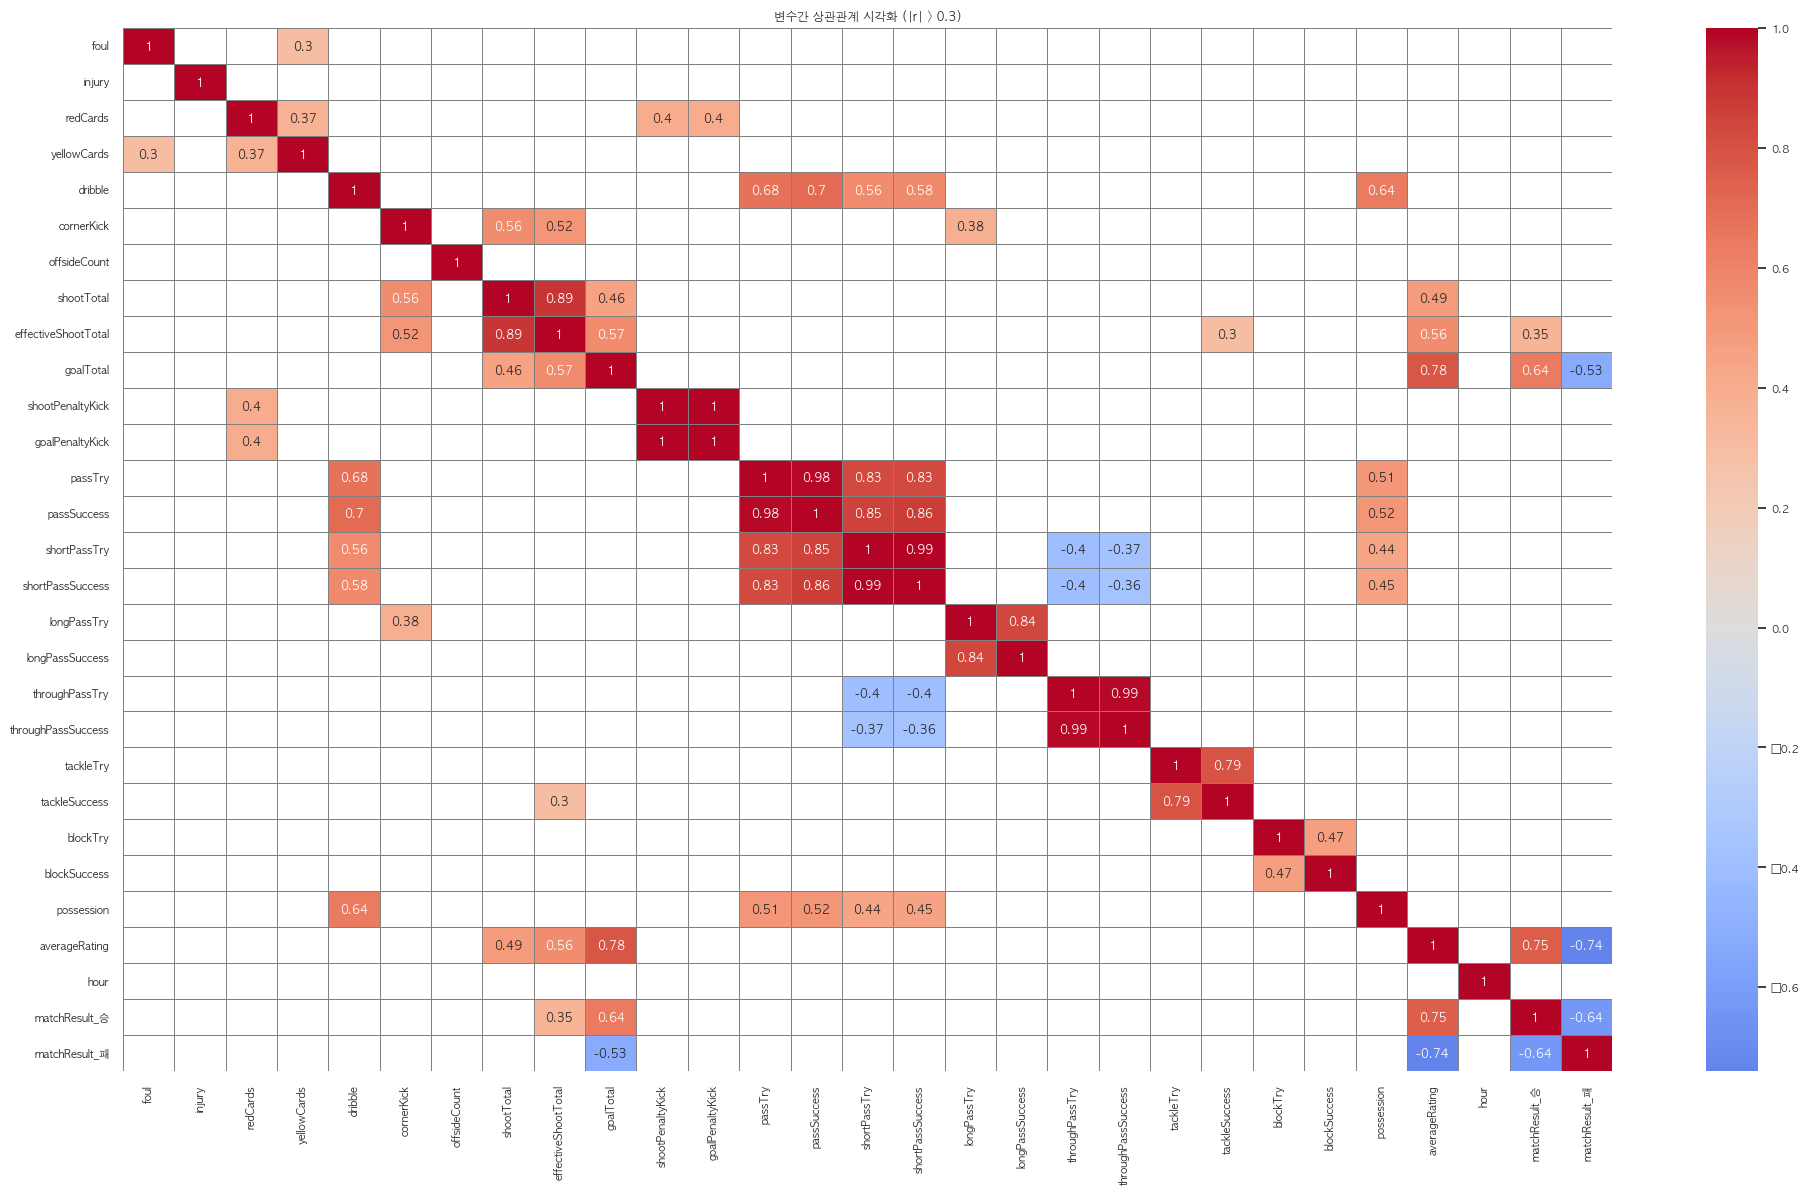

In [120]:
# ouid 제외
corr_df = encoded_df.drop(columns='ouid')

# 상관계수 계산
corr_matrix = corr_df.corr()

# 마스킹 조건: -0.3 ~ 0.3 사이 값은 흰색 처리
mask = (corr_matrix < 0.3) & (corr_matrix > -0.3)

# 시각화
sns.set_theme(style='whitegrid', rc={'figure.figsize': (20, 12)}, font_scale=0.7, font='AppleGothic')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, center=0, linewidths=0.5, linecolor='gray')

plt.title('변수간 상관관계 시각화 (|r| > 0.3)')
plt.grid(False)
plt.tight_layout()
plt.show()

> 전체 변수 상관관계 분석 인사이트 정리

상관계수가 0.3이상이거나 -0.3이하인 관계만 표현

1. 드리블, 점유율, 패스(특히 짧은 패스)는 높은 양의 상관관계 > 티키타카 스타일로 점유율을 지배하는 스타일을 의미
2. 레드카드는 페널티킥, 옐로카드와 높은 양의 상관관계 > 직관적으로 당연함
3. 코너킥은 슈팅, 유효슛, 롱패스와 높은 양의 상관관계 > 코너킥이 유의미한 골찬스를 만든다.
4. 유효슛은 경기 승리, 평균 평점, 태클 성공, 골, 슛, 코너킥과 높은 양의 상관관계 > 유효슛이 경기 승리에 높은 영향을 미칠 것
5. 짧은 패스는 스루패스와 높은 음의 상관관계 > 짧은 패스 축구 스타일과 스루패스 스타일은 대척점인가?
6. 패스 시도와 태클 성공 매우 높은 양의 상관관계 > 총 패스 시도는 짧은 패스와 높은 상관관계, 따라서 짧은 패스를 구사하는 티키타카 스타일 유저는 선수간격이 좁아 태클도 많이 시도하게 되는 것이라 추정된다.


> 눈에 띄는 인사이트

1. 드리블, 점유율, 패스(특히 짧은 패스)는 높은 양의 상관관계
2. 짧은 패스는 스루패스와 높은 음의 상관관계/패스 종류 중에서 전체 패스와 가장 높은 양의 상관관계
3. 패스 시도와 태클 성공 매우 높은 양의 상관관계

#### ㄴ 시각화

- 경기 승리와의 상관관계 분석

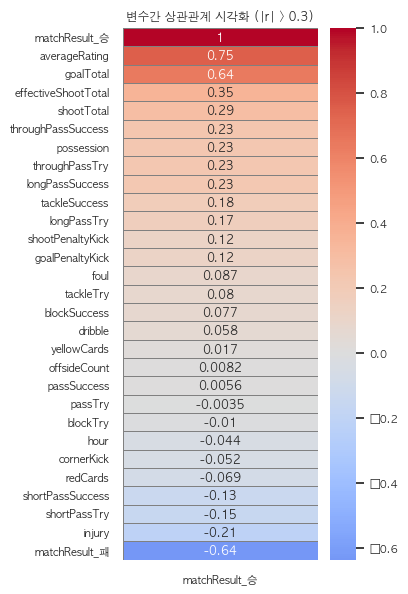

In [132]:
# ouid 제외
corr_df = encoded_df.drop(columns='ouid')

# 상관계수 계산
corr_matrix = corr_df.corr()[['matchResult_승']]

# 마스킹 조건: -0.3 ~ 0.3 사이 값은 흰색 처리
#mask = (corr_matrix < 0.3) & (corr_matrix > -0.3)

# 시각화
sns.set_theme(style='whitegrid', rc={'figure.figsize': (4, 6)}, font_scale=0.7, font='AppleGothic')
sns.heatmap(corr_matrix.sort_values(by='matchResult_승', ascending=False), annot=True, cmap='coolwarm', center=0, linewidths=0.5, linecolor='gray')

plt.title('변수간 상관관계 시각화 (|r| > 0.3)')
plt.grid(False)
plt.tight_layout()
plt.show()

> 인사이트

1. 양의 상관관계: 슛 , 스루패스, 롱패스
2. 음의 상관관계: 슛 , 짧은패스, 부상

#### ㄴ 결론

나는 숏 패스 위주로 점유율을 지배하는 경기 스타일을 고수하고 있으나, 승리와 높은 양의 상관관계에 있는 패스는 스루패스나 롱패스이다.